In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
from scipy.stats import norm
from scipy.optimize import fsolve
from selectinf.base import selected_targets
from selectinf.QR_lasso import QR_lasso
from selectinf.randomization import randomization
from selectinf.approx_reference import approximate_grid_inference
from selectinf.exact_reference import exact_grid_inference
from selectinf.regreg_QR.QR_population import *

np.set_printoptions(threshold=np.inf)

In [2]:
# generate covariance matrix
def cov_generate(std, rho):
    p = len(std)
    R = np.abs(np.subtract.outer(np.arange(p), np.arange(p)))
    return np.outer(std, std) * (rho ** R)

# estimate AR covariance matrix
def cov_estmate(X, t = 100):
    ARrho = []
    for s in np.random.sample(t):
        Xr = X[int(s * n)]
        ARrho.append(np.corrcoef(Xr[1:], Xr[:-1])[0, 1])
    ARrho = np.mean(ARrho)
    ARcov = ARrho ** (np.abs(np.subtract.outer(np.arange(p), np.arange(p))))
    return ARcov

# Homogeneous model

$$
    y_i= \boldsymbol{x}_i ^ \top \boldsymbol{\beta}^* + \varepsilon_i-F_{\varepsilon_i}^{-1}(\tau)
$$

For our targets, we consider two different targets for implement purpose:
1. the first target solves population smoothed quantile loss function
2. the second target solves check loss function


Next, we focus on the details about first target.
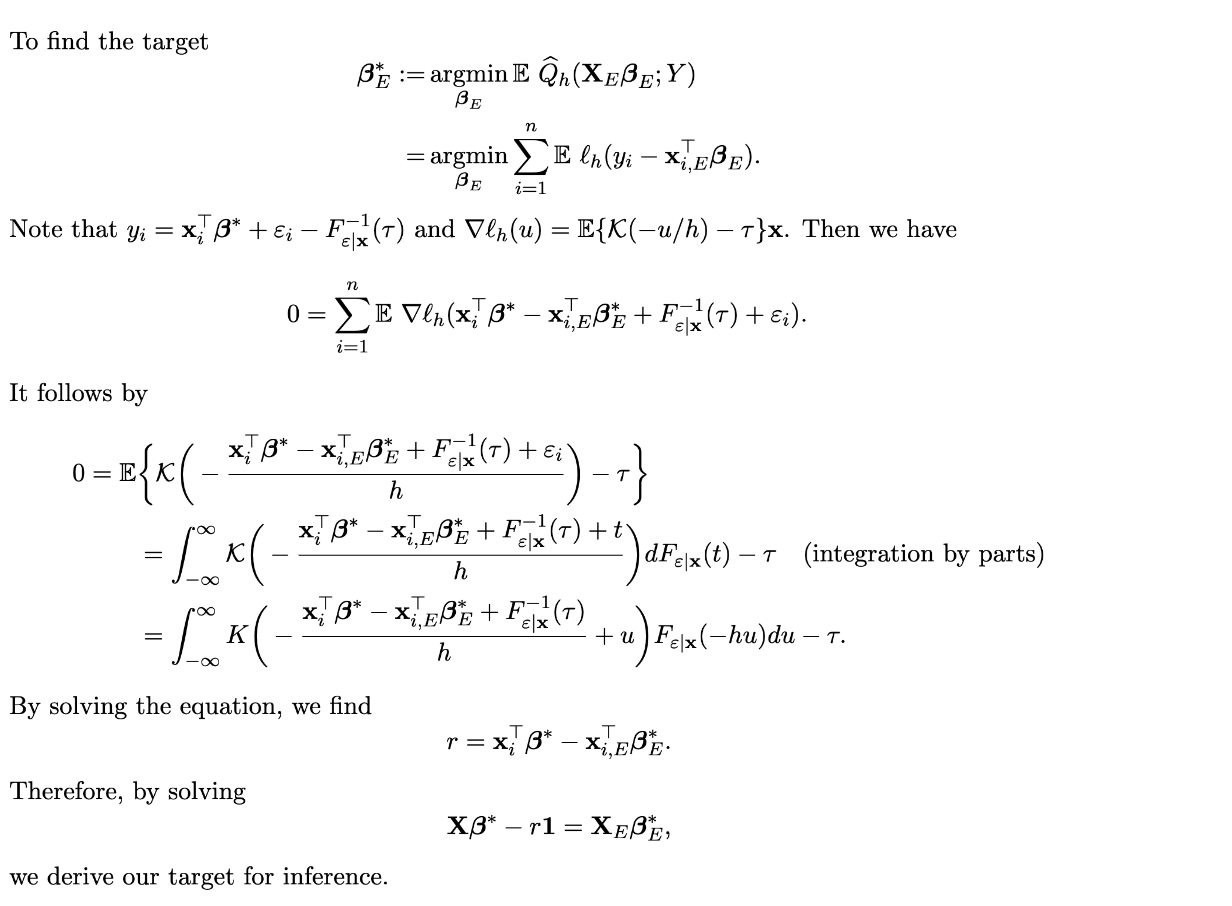

In [3]:
# set random seed
np.random.seed(2023)

# model setting
num_set = []
coverage_exact1 = []
coverage_exact2 = []
coverage_approx1 = []
coverage_approx2 = []
length_exact = []
length_approx = []

n, p = 800, 200
mu, Sig = np.zeros(p), cov_generate(np.ones(p), 0.5)
beta = np.zeros(p)
beta[0:5] = 1
tau = 0.75
reps = 500

In [4]:
for i in range(reps):
    # print(i)
    # generate sample
    X = rgt.multivariate_normal(mean=mu, cov=Sig, size=n)
    Y = X.dot(beta) + rgt.normal(loc=0, scale=1, size=n) - norm.ppf(tau, loc=0, scale=1)

    # inference
    randomizer = randomization.isotropic_gaussian(shape=(p,), scale=0.75*(1/np.sqrt(n)))
    conv = QR_lasso(X,
                    Y,
                    tau=tau,
                    randomizer=randomizer)
    conv.fit()
    conv.setup_inference()
    query_spec = conv.specification
    target_spec, bw = selected_targets(X,
                                       Y,
                                       tau=tau,
                                       solution=conv.observed_soln)

    # nonzero set of penalized estimator
    nonzero_set = np.nonzero(conv.observed_soln)[0]
    num_set.append(nonzero_set.size)
    # print(conv.observed_soln[nonzero_set])
    # print(target_spec.observed_target)

    # beta target    
    value = fsolve(find_root, 0, args=(tau, bw, 'Gaussian'))
    beta_target1 = np.linalg.pinv(X[:, nonzero_set]).dot(X.dot(beta) - value)
    beta_target2 = np.linalg.pinv(X[:, nonzero_set]).dot(X.dot(beta))
    # print(beta_target1)
    # print(beta_target2)

    # exact pivot
    exact_grid_inf = exact_grid_inference(query_spec, target_spec)
    lci, uci = exact_grid_inf._intervals(level=0.90)
    length = uci - lci
    coverage1 = (lci < beta_target1) * (uci > beta_target1)
    coverage2 = (lci < beta_target2) * (uci > beta_target2)
    coverage_exact1.append(np.mean(coverage1))
    coverage_exact2.append(np.mean(coverage2))
    length_exact.append(np.mean(length))

    # approximate pivot
    approximate_grid_inf = approximate_grid_inference(query_spec, target_spec)
    lci, uci = approximate_grid_inf._intervals(level=0.90)
    length = uci - lci
    coverage1 = (lci < beta_target1) * (uci > beta_target1)
    coverage2 = (lci < beta_target2) * (uci > beta_target2)
    coverage_approx1.append(np.mean(coverage1))
    coverage_approx2.append(np.mean(coverage2))
    length_approx.append(np.mean(length))


In [5]:
# result summary
results = pd.DataFrame({'exact': [np.mean(coverage_exact1), np.mean(coverage_exact2), np.mean(length_exact)], 
                        'approx': [np.mean(coverage_approx1), np.mean(coverage_approx2), np.mean(length_approx)]},
                       index=['Coverage rate (target 1)', 'Coverage rate (target 2)', 'CI length']).round(4) 
results

,exact,approx
Coverage rate (target 1),0.8957,0.8963
Coverage rate (target 2),0.8966,0.8973
CI length,0.1976,0.1958


# Linear heterogeneous model

$$
    y_i= \boldsymbol{x}_i ^ \top \boldsymbol{\beta}^* + 0.5 (1 + 2 x_{i,5}) (\varepsilon_i-F_{\varepsilon_i}^{-1}(\tau))
$$

In [6]:
# set random seed
np.random.seed(2023)

# model setting
num_set = []
coverage_exact = []
coverage_approx = []
length_exact = []
length_approx = []

n, p = 800, 200
mu, Sig = np.zeros(p), cov_generate(np.ones(p), 0.5)
beta = np.zeros(p)
beta[0:5] = 1
tau = 0.75
reps = 500

In [7]:
for i in range(reps):
    # print(i)
    # generate sample
    X = rgt.multivariate_normal(mean=mu, cov=Sig, size=n)
    X[:,5] = norm.cdf(X[:,5])
    Y = X.dot(beta) + 0.5 * (1 + 2 * X[:,5]) * (rgt.normal(loc=0, scale=1, size=n) - norm.ppf(tau, loc=0, scale=1))
    # (1 + X[:,5])
        
    # inference
    randomizer = randomization.isotropic_gaussian(shape=(p,), scale=0.75*(1/np.sqrt(n)))
    conv = QR_lasso(X,
                    Y,
                    tau=tau,
                    randomizer=randomizer)
    conv.fit()
    conv.setup_inference()
    query_spec = conv.specification
    target_spec, bw = selected_targets(X,
                                       Y,
                                       tau=tau,
                                       solution=conv.observed_soln)

    # nonzero set of penalized estimator
    nonzero_set = np.nonzero(conv.observed_soln)[0]
    num_set.append(nonzero_set.size)
    # print(conv.observed_soln[nonzero_set])
    # print(target_spec.observed_target)

    # beta target
    beta_target = np.linalg.pinv(X[:, nonzero_set]).dot(X.dot(beta))
    # print(beta_target)

    # exact pivot
    exact_grid_inf = exact_grid_inference(query_spec, target_spec)
    lci, uci = exact_grid_inf._intervals(level=0.90)
    length = uci - lci
    coverage = (lci < beta_target) * (uci > beta_target)
    coverage_exact.append(np.mean(coverage))
    length_exact.append(np.mean(length))

    # approximate pivot
    approximate_grid_inf = approximate_grid_inference(query_spec, target_spec)
    lci, uci = approximate_grid_inf._intervals(level=0.90)
    length = uci - lci
    coverage = (lci < beta_target) * (uci > beta_target)
    coverage_approx.append(np.mean(coverage))
    length_approx.append(np.mean(length))

In [8]:
# result summary
results = pd.DataFrame({'exact': [np.mean(coverage_exact), np.mean(length_exact)],
                        'approx': [np.mean(coverage_approx), np.mean(length_approx)]},
                       index=['Coverage rate', 'CI length']).round(4)
results

,exact,approx
Coverage rate,0.9017,0.8960
CI length,0.1800,0.1786


# Quadratic heterogeneous model

$$
    y_i= \boldsymbol{x}_i ^ \top \boldsymbol{\beta}^* + 0.5 (1 + x_{i,5}) ^ 2 (\varepsilon_i-F_{\varepsilon_i}^{-1}(\tau))
$$

In [9]:
# set random seed
np.random.seed(2023)

# model setting
num_set = []
coverage_exact = []
coverage_approx = []
length_exact = []
length_approx = []

n, p = 800, 200
mu, Sig = np.zeros(p), cov_generate(np.ones(p), 0.5)
beta = np.zeros(p)
beta[0:5] = 1
tau = 0.75
reps = 500

In [10]:
for i in range(reps):
    # print(i)
    # generate sample
    X = rgt.multivariate_normal(mean=mu, cov=Sig, size=n)
    X[:,5] = norm.cdf(X[:,5])
    Y = X.dot(beta) + 0.5 * (1 + X[:,5]) ** 2 * (rgt.normal(loc=0, scale=1, size=n) - norm.ppf(tau, loc=0, scale=1))

    # inference
    randomizer = randomization.isotropic_gaussian(shape=(p,), scale=0.75*(1/np.sqrt(n)))
    conv = QR_lasso(X,
                    Y,
                    tau=tau,
                    randomizer=randomizer)
    conv.fit()
    conv.setup_inference()
    query_spec = conv.specification
    target_spec, bw = selected_targets(X,
                                       Y,
                                       tau=tau,
                                       solution=conv.observed_soln)

    # nonzero set of penalized estimator
    nonzero_set = np.nonzero(conv.observed_soln)[0]
    num_set.append(nonzero_set.size)
    # print(conv.observed_soln[nonzero_set])
    # print(target_spec.observed_target)

    # beta target
    beta_target = np.linalg.pinv(X[:, nonzero_set]).dot(X.dot(beta))
    # print(beta_target)

    # exact pivot
    exact_grid_inf = exact_grid_inference(query_spec, target_spec)
    lci, uci = exact_grid_inf._intervals(level=0.90)
    length = uci - lci
    coverage = (lci < beta_target) * (uci > beta_target)
    coverage_exact.append(np.mean(coverage))
    length_exact.append(np.mean(length))

    # approximate pivot
    approximate_grid_inf = approximate_grid_inference(query_spec, target_spec)
    lci, uci = approximate_grid_inf._intervals(level=0.90)
    length = uci - lci
    coverage = (lci < beta_target) * (uci > beta_target)
    coverage_approx.append(np.mean(coverage))
    length_approx.append(np.mean(length))

In [11]:
# result summary
results = pd.DataFrame({'exact': [np.mean(coverage_exact), np.mean(length_exact)],
                        'approx': [np.mean(coverage_approx), np.mean(length_approx)]},
                       index=['Coverage rate', 'CI length']).round(4)
results

,exact,approx
Coverage rate,0.8917,0.8914
CI length,0.2012,0.1995
